# Manual inputs

This script should be executed at the start of the project. It requires access to Google Drive for data retrieval, so ensure that your Google account is connected. Additionally, the script reinstalls a necessary package, which requires manual input during execution. Please follow the prompts carefully to complete the installation process before proceeding with further code execution.

## Prelims

The results presented in this paper rely on the following package versions:

JAX: 0.4.31; TensorFlow: 2.17.0; Neural Tangents: 0.6.6.

In [ ]:
!pip install -q --upgrade pip
!pip install --upgrade jax==0.4.31 jaxlib==0.4.31
!pip install tensorflow==2.17.0
!pip install -q git+https://www.github.com/google/neural-tangents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 40.0 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26


  Preparing metadata (setup.py) ... done


In [ ]:
import jax
import tensorflow as tf
import neural_tangents as nt

print("JAX version:", jax.__version__) # 0.4.31
print("TensorFlow version:", tf.__version__) # 2.17.0
print("Neural Tangents version:", nt.__version__) #0.6.6

JAX version: 0.4.31
TensorFlow version: 2.17.0
Neural Tangents version: 0.6.6


Connect to Google Drive to access the required files. If you plan to save the file locally, modifications to the code will be necessary.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prep

This code loads the data and performs minor pre-processing. Before running the code, ensure you have the following two files: inforce.csv; fmv_seriatim.csv. These can be downloaded at https://www2.math.uconn.edu/~gan/software.html, under *Aggregate results*.

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/VA/
import pandas as pd
import numpy as np

datpolicies = pd.read_csv('inforce.csv')
datvals = pd.read_csv('fmv_seriatim.csv')
datcombined = datpolicies.join(datvals.set_index('recordID'), on = 'recordID')
#use matDate, birthDate, issueTime and currentDate to define
datcombined['matTime'] = (datcombined.matDate - datcombined.currentDate)/365.25 #time to maturity
datcombined['Age'] =   (datcombined.currentDate - datcombined.birthDate)/365.25 #age
datgreeks = pd.read_csv('Greek.csv')
#datcombined['issueTime'] =(datcombined.currentDate - datcombined.issueDate)/365.25 #time since issue
mydat = datcombined #190000 policies
mydat_y = mydat["base:base"].astype('float') #contract valuation: base (dependent)
mydat_y = np.array(mydat_y).flatten()

mydat = mydat.iloc[:, np.r_[2, 3, 11:13, 15:25, 72,73]] #gender, productType, gbAmt, GMWBBalance, FundValue1-10, 2 derived variables
#all products: include withdrawal variables
mydat['gender'] = np.where(mydat['gender']=='M', 1, 0)
mave = np.absolute(mydat_y).mean()
datcombined2 = datcombined.join(datgreeks.set_index('recordID'), on = 'recordID')

#for Greeks
datgreeks2 = datcombined2.iloc[:, -13:]
list1 = ['base'] + [str(x)+'_'+str(y) for x in range(1, 6) for y in ['D', 'U']]+['base']*16
list2 = ['base']*11 + [str(x)+'y_'+str(y) for x in [1, 2, 3, 4, 5, 7, 10, 30] for y in ['D', 'U']]
colnames = [str(x)+':'+str(y) for (x, y) in zip(list2, list1)]
datvals2 = datcombined2[colnames]

#for numeric variables, perform minmax scaling
for i in range(2, len(mydat.columns)):
  currentcolumn = mydat.iloc[:, i]
  mydat.iloc[:, i] = (currentcolumn - currentcolumn.min())/(currentcolumn.max()-currentcolumn.min())

/content/drive/MyDrive/Colab Notebooks/VA


<ipython-input-41-f7b2983322a6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydat['gender'] = np.where(mydat['gender']=='M', 1, 0)


In [ ]:
import tensorflow as tf
from random import seed, sample
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Softmax
#from keras.layers.embeddings import Embedding
from keras.utils import to_categorical, set_random_seed
from keras.optimizers import Adam, SGD
from keras.constraints import NonNeg
from keras import initializers

#create one hot encoding of categorical
from keras.utils import to_categorical
from copy import deepcopy


productTypes = mydat['productType'].unique()
for i in range(len(productTypes)):
  mydat.loc[mydat['productType'] == productTypes[i], 'productType'] = i
mydat_emb = deepcopy(mydat)
#mydat_emb will be used for embedding encoding for NNs
productType_one_hot = to_categorical(mydat['productType'])
productType_one_hot = pd.DataFrame(productType_one_hot, columns = productTypes)
mydat = mydat.loc[:, mydat.columns != 'productType']
mydat = mydat.join(productType_one_hot)
#mydat will be used for one-hot encoding for NNs


# Sampling methods

At the beginning of each run, select only one of the following methods: stratified random sampling, hierarchical k-means, or conditional cLHS. Ensure that the random state is set based on the run number for reproducibility.

In [ ]:
import random
mydat_array = mydat.values #certain methods require data to be stored in an array rather than a data frame
random_state = 10
n = 680
ndat = len(mydat_y) #190,000

random.seed(1)

## Stratified random sampling

The results presented in the paper are the average of replicates generated using the following five seeds: 10, 20, 30, 40, and 50. For single replicates, the results are based on seed 10.

In [ ]:
from sklearn.model_selection import train_test_split


mydat_train, mydat_val, mydat_train_emb, mydat_val_emb, mydat_train_y, mydat_val_y  = train_test_split(mydat_array, mydat_emb, mydat_y, test_size=(n/2)/ndat,train_size=n/ndat,
                                                                                                       stratify = mydat_emb['productType'], random_state =random_state)
def makenpfloat(vec):
  return np.array(vec, dtype = np.float32)

mydat_train = makenpfloat(mydat_train)
mydat_val = makenpfloat(mydat_val)
mydat_train_y = makenpfloat(mydat_train_y).flatten()
mydat_val_y = makenpfloat(mydat_val_y).flatten()


The following code is intended exclusively for Greeks.

In [ ]:
mydat_greeks_train = datgreeks2.loc[mydat_train_emb.index]
mydat_greeks_val = datgreeks2.loc[mydat_val_emb.index]
mydat_vals_train = datvals2.loc[mydat_train_emb.index]
mydat_vals_val = datvals2.loc[mydat_val_emb.index]

## Hierarchical k-means

This code implements hierarchical k-means as described in the Gan and Valdez book. In broader machine learning contexts, this method is commonly referred to as bisecting k-means. The results presented in the paper are the average of replicates generated using the following five seeds: 10, 20, 30, 40, and 50.

In [ ]:
from sklearn.cluster import BisectingKMeans
from scipy.cluster.vq import vq
mydat_array =mydat.values


mykmeans = BisectingKMeans(n_clusters = n, random_state = random_state, init = 'k-means++', n_init = 1, bisecting_strategy = 'largest_cluster').fit(mydat_array)


def getclosestinds(dat, kmeans):
  all_data = [ i for i in range(dat.shape[0]) ]
  m_clusters = kmeans.labels_.tolist()
  centers = np.array(kmeans.cluster_centers_)
  n_clusters = centers.shape[0]

  closest_data = []
  for i in range(n_clusters):
      center_vec = centers[i].reshape(1,-1)
      data_idx_within_i_cluster = [ idx for idx, clu_num in enumerate(m_clusters) if clu_num == i ]

      one_cluster_dat = np.zeros( (  len(data_idx_within_i_cluster) , centers.shape[1] ) )
      for row_num, data_idx in enumerate(data_idx_within_i_cluster):
          one_row = dat[data_idx]
          one_cluster_dat[row_num] = one_row

      closest, _ = vq(center_vec, one_cluster_dat)
      closest_idx_in_one_cluster_dat = closest[0]
      closest_data_row_num = data_idx_within_i_cluster[closest_idx_in_one_cluster_dat]
      data_id = all_data[closest_data_row_num]

      closest_data.append(data_id)

  closest_data = list(set(closest_data))

  assert len(closest_data) == n_clusters

  return closest_data

mydat_train_inds = getclosestinds(mydat_array, mykmeans)



from sklearn.model_selection import train_test_split
mydat_train = mydat_array[mydat_train_inds]
mydat_train_y = mydat_y[mydat_train_inds]
mydat_train_emb = mydat_emb.iloc[mydat_train_inds]


mydat_y_notrain = np.delete(mydat_y, mydat_train_inds)
mydat_array_notrain = np.delete(mydat_array, mydat_train_inds, axis=0)
mydat_emb_notrain = mydat_emb[~mydat_emb.index.isin(mydat_train_inds)]
productType_notrain = mydat_emb_notrain['productType']
mydat_val, _, mydat_val_emb, _, mydat_val_y, _ = train_test_split(mydat_array_notrain, mydat_emb_notrain, mydat_y_notrain, train_size=(n/2)/(ndat-n), stratify = productType_notrain, random_state =random_state)



## Conditioned latin hypercube sampling (cLHS)

This code performs cLHS. The results presented in the paper are the average of replicates generated using the following five seeds: 10, 20, 30, 40, and 50.

In [ ]:
!pip install clhs
import clhs as cl


sampled=cl.clhs(mydat_emb, n, max_iterations=1000, random_state = random_state)
# then, validation indices are sampled from outside of training indices, using
# stratified random sampling

from sklearn.model_selection import train_test_split

mydat_train_inds = sampled['sample_indices']
mydat_train = mydat_array[mydat_train_inds]
mydat_train_y = mydat_y[mydat_train_inds]
mydat_train_emb = mydat_emb.iloc[mydat_train_inds]


mydat_y_notrain = np.delete(mydat_y, mydat_train_inds)
mydat_array_notrain = np.delete(mydat_array, mydat_train_inds, axis=0)
mydat_emb_notrain = mydat_emb[~mydat_emb.index.isin(mydat_train_inds)]
productType_notrain = mydat_emb_notrain['productType']
mydat_val, _, mydat_val_emb, _, mydat_val_y, _ = train_test_split(mydat_array_notrain, mydat_emb_notrain, mydat_y_notrain, train_size=(n/2)/(190000-n), stratify = productType_notrain, random_state =random_state)

  Preparing metadata (setup.py) ... done
  Created wheel for clhs: filename=clhs-1.0.2-py3-none-any.whl size=9790 sha256=c59f3b0a00433b61d8cbcce0cac4fe6b25f7a879051a9263f103edaf4c0c8158
  Stored in directory: /root/.cache/pip/wheels/38/f2/ed/264b8cb2bbd5b97222e4f091b14bc1c6dd837c7abf30443201
Successfully built clhs


cLHS: 91%|█████████ |907/1000 [Elapsed time: 5.80972695350647, ETA: 0.7257527427932804, 128.14it/s] /usr/local/lib/python3.10/dist-packages/clhs/clhs.py:760: RuntimeWarning: overflow encountered in exp
  anneal_fac = np.exp(-delta_obj / temp)
cLHS: 93%|█████████▎|933/1000 [Elapsed time: 6.02297306060791, ETA: 0.5331041294133011, 125.68it/s] /usr/local/lib/python3.10/dist-packages/clhs/clhs.py:760: RuntimeWarning: overflow encountered in exp
  anneal_fac = np.exp(-delta_obj / temp)
cLHS: 97%|█████████▋|972/1000 [Elapsed time: 6.34163498878479, ETA: 0.2275191727144864, 123.07it/s]  /usr/local/lib/python3.10/dist-packages/clhs/clhs.py:760: RuntimeWarning: overflow encountered in exp
  anneal_fac = np.exp(-delta_obj / temp)
cLHS: 98%|█████████▊|985/1000 [Elapsed time: 6.441846132278442, ETA: 0.12004685102924097, 124.95it/s]/usr/local/lib/python3.10/dist-packages/clhs/clhs.py:760: RuntimeWarning: overflow encountered in exp
  anneal_fac = np.exp(-delta_obj / temp)
cLHS:100%|█████████▉|998/1

#Trees

The paper explores three methods: bagging, bias-corrected bagging, and boosting.

## Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor

reg = BaggingRegressor(n_estimators=300, random_state=0, oob_score=True).fit(mydat_train, mydat_train_y)

mypreds_full = reg.predict(mydat_array)
mypreds_val = reg.predict(mydat_val)
mypreds = reg.predict(mydat_train)

errs = mypreds_full.flatten() - mydat_y.flatten()

print(np.mean(np.square(errs))/1000000)
print(np.mean(np.absolute(errs))/1000)
print(np.sqrt(np.mean(np.square(errs)))/mave*100)
print(np.mean(np.absolute(errs))/mave*100)
print(np.mean(errs)/mydat_y.mean())

2688.1189249238923
30.583535498456747
51.253657098781936
30.233491811118913
0.009126183053668769


##Bias-corrected bagging

In [ ]:
oob_pred_train = reg.oob_prediction_
bias_train = oob_pred_train - mydat_train_y
regbias = BaggingRegressor(n_estimators=300, random_state=0).fit(mydat_train, bias_train)

mypreds_full = reg.predict(mydat_array)-regbias.predict(mydat_array)
mypreds_val = reg.predict(mydat_val)-regbias.predict(mydat_val)
mypreds = reg.predict(mydat_train)-regbias.predict(mydat_train)

errs = mypreds_full.flatten() - mydat_y.flatten()

print(np.mean(np.square(errs))/1000000)
print(np.mean(np.absolute(errs))/1000)
print(np.sqrt(np.mean(np.square(errs)))/mave*100)
print(np.mean(np.absolute(errs))/mave*100)
print(np.mean(errs)/mydat_y.mean())

2903.293524983555
28.17172130689984
53.26551036447196
27.849282025626472
-0.016365147761239162


##Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
nest = [500, 1000, 2000]
maxdepth = [1, 3, 5]
minsamplesleaf = [1, 5, 10]
learningrate = [0.01, 0.1, 0.2]
boost_mat = np.zeros((81, 5))


ncount = 0
for i in range(3):
  currentnest = nest[i]
  for j in range(3):
    currentmaxdepth = maxdepth[j]
    for k in range(3):
      currentminsamplesleaf = minsamplesleaf[k]
      for l in range(3):
        print(ncount)
        currentlearningrate = learningrate[l]
        booster = GradientBoostingRegressor(n_estimators=currentnest,
                                            learning_rate = currentlearningrate,
                                            max_depth = currentmaxdepth,
                                            min_samples_leaf=currentminsamplesleaf,
                                            random_state=0).fit(mydat_train, mydat_train_y)
        val_preds = booster.predict(mydat_val)
        val_error = np.mean(np.square(val_preds.flatten() - mydat_val_y.flatten()))
        boost_mat[ncount] = [currentnest, currentmaxdepth, currentminsamplesleaf, currentlearningrate, val_error]



        ncount = ncount+1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
minind = np.argmin(boost_mat[:, 4])
mynest = int(boost_mat[minind, 0])
mymaxdepth = int(boost_mat[minind, 1])
myminsamples = int(boost_mat[minind, 2])
mylearning = boost_mat[minind, 3]
booster = GradientBoostingRegressor(n_estimators=mynest, learning_rate = mylearning, max_depth = mymaxdepth, min_samples_leaf=myminsamples, random_state=0).fit(mydat_train, mydat_train_y)

mypreds_full = booster.predict(mydat_array)
mypreds_val = booster.predict(mydat_val)
mypreds = booster.predict(mydat_train)

errs = mypreds_full.flatten() - mydat_y.flatten()

print(np.mean(np.square(errs))/1000000)
print(np.mean(np.absolute(errs))/1000)
print(np.sqrt(np.mean(np.square(errs)))/mave*100)
print(np.mean(np.absolute(errs))/mave*100)
print(np.mean(errs)/mydat_y.mean())

1845.4511999744511
25.096442636260985
42.46703132729037
24.809201440098345
0.020151650567711465


# Finite NN

## One-hot encoding

In [ ]:
K.clear_session()
set_random_seed(1)


k = 128
inputdata = Input((34, ))
mydense = Dense(k, activation = 'relu')(inputdata)
mydense = Dense(int(k/2), activation = 'relu')(mydense)
myval = Dense(1)(mydense)

inputs = inputdata
outputs = myval

m = KerasModel(inputs = inputs, outputs=outputs)
m.compile(optimizer=Adam(), loss='mse')
#m.summary()
callback = EarlyStopping(monitor='val_loss', patience=50)
m.fit(x=mydat_train, y=mydat_train_y, epochs = 20000, validation_data = (mydat_val, mydat_val_y), callbacks = [callback], verbose = 0, batch_size = n)

In [ ]:
mypreds_full = m.predict(x=mydat_array)
mypreds_val = m.predict(x=mydat_val)
mypreds = m.predict(x=mydat_train)

errs = mypreds_full.flatten() - mydat_y.flatten()

print(np.mean(np.square(errs))/1000000)
print(np.mean(np.absolute(errs))/1000)
print(np.sqrt(np.mean(np.square(errs)))/mave*100)
print(np.mean(np.absolute(errs))/mave*100)
print(np.mean(errs)/mydat_y.mean())


5938/5938 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
694.2738266048668
15.303218239298548
26.047498181076143
15.128065339108513
0.026120714890647795


In [ ]:
for i in range(19):
  print("Product type:" + str(i+1))
  currenterrs = errs[10000*i:(10000*i+10000)]
  currenty = mydat_y[10000*i:(10000*i+10000)]
  currentmave = np.mean(np.abs(currenty))
  currentmse = np.mean(np.square(currenterrs))
  print(currentmse/1000000)
  print(np.sqrt(currentmse)/currentmave)
  print(np.mean(currenterrs)/np.mean(currenty))

Product type:1
183.47643966549677
0.39129161773743193
-0.0006935991460613565
Product type:2
1878.589386982343
0.1371328665561452
0.013118943047495061
Product type:3
188.66827908947027
0.3830771982497577
0.14106062344897866
Product type:4
641.3151089578128
0.36024020928790657
0.07953607974576944
Product type:5
221.77844110206675
0.3178048978418479
0.06633715109723426
Product type:6
463.2954285027623
0.45531886897754154
-0.015906215684053884
Product type:7
1388.5828105684916
0.7568603651594896
-0.10495115957853395
Product type:8
42.78755926014768
1.245956612534637
-0.0843358182144588
Product type:9
230.88142312797999
0.31219606282831136
0.059076928572447764
Product type:10
295.742945999504
0.35115688110038684
0.044727075148855745
Product type:11
489.4722456226593
0.4385905701341235
0.1087630761411987
Product type:12
412.06265777118335
0.27608141629827326
0.049636163616487136
Product type:13
58.142876523614525
0.7497570228243251
-0.03865545344881798
Product type:14
48.90567541993699
0.693

## With embeddings

In [ ]:
from keras.layers import Embedding
K.clear_session()
set_random_seed(1)



input_product_type = Input(shape=(1,))
output_product_type = Embedding(19, 5, name='product_type_embedding')(input_product_type)
output_product_type = Reshape(target_shape=(5,))(output_product_type)
input_mat = Input(shape = (15, ))
output_mat = input_mat
input_list = [input_mat, input_product_type]
outputs =[output_mat, output_product_type]
outputs = Concatenate()(outputs)
k = 128

outputs = Dense(k, activation = 'relu')(outputs)
outputs = Dense(int(k/2), activation = 'relu')(outputs)
outputs = Dense(1)(outputs)

m2 = KerasModel(inputs = input_list, outputs=outputs)
m2.compile(optimizer=Adam(), loss='mse')
#m2.summary()
callback = EarlyStopping(monitor='val_loss', patience=50)


def split_features(dat_emb):
  product_type = np.array(dat_emb['productType']).astype('float')
  dat_emb = np.array(dat_emb.loc[:, dat_emb.columns != 'productType'].values)
  return [dat_emb, product_type]

m2.fit(x=split_features(mydat_train_emb), y=mydat_train_y, epochs = 20000, validation_data = (split_features(mydat_val_emb), mydat_val_y), callbacks = [callback], verbose = 2, batch_size = n)


Streaming output truncated to the last 5000 lines.
Epoch 10779/20000
1/1 - 0s - 72ms/step - loss: 1087942528.0000 - val_loss: 1258240512.0000
Epoch 10780/20000
1/1 - 0s - 62ms/step - loss: 1087448960.0000 - val_loss: 1258270720.0000
Epoch 10781/20000
1/1 - 0s - 63ms/step - loss: 1086932480.0000 - val_loss: 1258088448.0000
Epoch 10782/20000
1/1 - 0s - 67ms/step - loss: 1086429184.0000 - val_loss: 1256362112.0000
Epoch 10783/20000
1/1 - 0s - 143ms/step - loss: 1085915520.0000 - val_loss: 1256419072.0000
Epoch 10784/20000
1/1 - 0s - 67ms/step - loss: 1085377792.0000 - val_loss: 1255677056.0000
Epoch 10785/20000
1/1 - 0s - 64ms/step - loss: 1084863616.0000 - val_loss: 1254000384.0000
Epoch 10786/20000
1/1 - 0s - 61ms/step - loss: 1084389120.0000 - val_loss: 1255117824.0000
Epoch 10787/20000
1/1 - 0s - 61ms/step - loss: 1083845504.0000 - val_loss: 1254210560.0000
Epoch 10788/20000
1/1 - 0s - 139ms/step - loss: 1083295872.0000 - val_loss: 1252024960.0000
Epoch 10789/20000
1/1 - 0s - 137ms/st

In [ ]:
m2preds_full = m2.predict(x=split_features(mydat_emb))
m2preds_val = m2.predict(x=split_features(mydat_val_emb))
m2preds = m2.predict(x=split_features(mydat_train_emb))

errs2 = m2preds_full.flatten() - mydat_y.flatten()

print(np.mean(np.square(errs2))/1000000)
print(np.mean(np.absolute(errs2))/1000)
print(np.sqrt(np.mean(np.square(errs2)))/mave*100)
print(np.mean(np.absolute(errs2))/mave*100)
print(np.mean(errs2)/mydat_y.mean())

5938/5938 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
699.4219014133438
14.932977704436835
26.143891565186976
14.76206239025223
0.010636112906442091


In [ ]:
for i in range(19):
  print("Product type:" + str(i+1))
  currenterrs = errs[10000*i:(10000*i+10000)]
  currenty = mydat_y[10000*i:(10000*i+10000)]
  currentmave = np.mean(np.abs(currenty))
  currentmse = np.mean(np.square(currenterrs))
  print(currentmse/1000000)
  print(np.sqrt(currentmse)/currentmave)
  print(np.mean(currenterrs)/np.mean(currenty))

Product type:1
183.47643966549677
0.39129161773743193
-0.0006935991460613565
Product type:2
1878.589386982343
0.1371328665561452
0.013118943047495061
Product type:3
188.66827908947027
0.3830771982497577
0.14106062344897866
Product type:4
641.3151089578128
0.36024020928790657
0.07953607974576944
Product type:5
221.77844110206675
0.3178048978418479
0.06633715109723426
Product type:6
463.2954285027623
0.45531886897754154
-0.015906215684053884
Product type:7
1388.5828105684916
0.7568603651594896
-0.10495115957853395
Product type:8
42.78755926014768
1.245956612534637
-0.0843358182144588
Product type:9
230.88142312797999
0.31219606282831136
0.059076928572447764
Product type:10
295.742945999504
0.35115688110038684
0.044727075148855745
Product type:11
489.4722456226593
0.4385905701341235
0.1087630761411987
Product type:12
412.06265777118335
0.27608141629827326
0.049636163616487136
Product type:13
58.142876523614525
0.7497570228243251
-0.03865545344881798
Product type:14
48.90567541993699
0.693

## Hejazi methodology

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

mydat_trainr, mydat_rep, mydat_trainr_y, mydat_rep_y = train_test_split(mydat_train_emb, mydat_train_y, test_size = 0.5, train_size = 0.5, random_state = random_state)
#print(len(mydat_rep), len(mydat_trainr), len(mydat_val))

def getcatdist(catvec2, catvec1):
  return 1*np.array(catvec2 != catvec1)

def getmaxdist(numvec2, numvec1):
  numvec2 = np.array(numvec2)
  numvec1 = np.array(numvec1)
  return 1*np.maximum(numvec2-numvec1, 0)

def getmindist(numvec2, numvec1):
  numvec2 = np.array(numvec2)
  numvec1 = np.array(numvec1)
  return 1*np.maximum(numvec1-numvec2, 0)

def getdist (list_rep, list_pred):
  datcat_rep = list_rep[0]
  datnum_rep = list_rep[1]
  datcat_pred = list_pred[0]
  datnum_pred = list_pred[1]
  distlist = []
  for i in range(len(list_rep[0])):
    currentcat = getcatdist(datcat_rep.iloc[i], datcat_pred)
    currentmax = getmaxdist(datnum_rep.iloc[i], datnum_pred)
    currentmin = getmindist(datnum_rep.iloc[i], datnum_pred)
    currentdist = np.concatenate([currentcat, currentmax, currentmin], axis=1)
    distlist.append(currentdist)
  return distlist

mydat_trainr_cat = mydat_trainr[['gender', 'productType']]
mydat_trainr_num = mydat_trainr.loc[:, ~mydat_trainr.columns.isin(['gender', 'productType'])]
mydat_trainr_list = [mydat_trainr_cat, mydat_trainr_num]
mydat_rep_cat = mydat_rep[['gender', 'productType']]
mydat_rep_num = mydat_rep.loc[:, ~mydat_rep.columns.isin(['gender', 'productType'])]
mydat_rep_list = [mydat_rep_cat, mydat_rep_num]
mydat_val_cat = mydat_val_emb[['gender', 'productType']]
mydat_val_num = mydat_val_emb.loc[:, ~mydat_val_emb.columns.isin(['gender', 'productType'])]
mydat_val_list = [mydat_val_cat, mydat_val_num]
mydat_cat = mydat_emb[['gender', 'productType']]
mydat_num = mydat_emb.loc[:, ~mydat_emb.columns.isin(['gender', 'productType'])]
mydat_list = [mydat_cat, mydat_num]


K.clear_session()
set_random_seed(1)
inputlist = []
denselist = []
nrep = len(mydat_rep)
for i in range(nrep):
  inputlist.append(Input((30, ), name = 'input'+str(i)))
  denselist.append(Dense(1, name = 'dense'+str(i))(inputlist[i]))

weights = Concatenate()(denselist)
weights = Softmax()(weights)
output = Dense(1, use_bias = False, name = 'weightedval', trainable=False)(weights)
m = KerasModel(inputs = inputlist, outputs = output)
m.get_layer('weightedval').set_weights([np.reshape(np.array(mydat_rep_y), (len(mydat_rep_y), 1))])
#this forces the weights to each multiply by the representative portfolio values
m.compile(optimizer=Adam(), loss='mse')
#m.summary()
callback = EarlyStopping(monitor='val_loss', patience=50)

In [ ]:
trainr_dist = getdist(mydat_rep_list, mydat_trainr_list)
val_dist = getdist(mydat_rep_list, mydat_val_list)
m.fit(x=trainr_dist, y=mydat_trainr_y, epochs = 20000, validation_data = (val_dist, mydat_val_y), callbacks = [callback], verbose = 1, batch_size = 16)

Epoch 1/20000
22/22 ━━━━━━━━━━━━━━━━━━━━ 117s 342ms/step - loss: 26157467648.0000 - val_loss: 20706230272.0000
Epoch 2/20000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 26045372416.0000 - val_loss: 20628797440.0000
Epoch 3/20000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 25959151616.0000 - val_loss: 20557805568.0000
Epoch 4/20000
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 25876733952.0000 - val_loss: 20490952704.0000
Epoch 5/20000
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 25796290560.0000 - val_loss: 20426905600.0000
Epoch 6/20000
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 25716844544.0000 - val_loss: 20364736512.0000
Epoch 7/20000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 25637732352.0000 - val_loss: 20303800320.0000
Epoch 8/20000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 25558499328.0000 - val_loss: 20243615744.0000
Epoch 9/20000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 25478830080.0000 - val_loss: 20183824384.0000
Epoch 10/20000
22/22 ━━━

In [ ]:
neval = 2048
nfull = len(mydat_y)
niters = nfull//neval +1
predslist = []
for i in range(niters):
  start = int(neval*i)
  stop = int(np.min([neval*(i+1), nfull]))
  currentlist = [mydat_cat[start:stop], mydat_num[start:stop]]
  currentdist = getdist(mydat_rep_list, currentlist)
  predslist.append(m.predict(x=currentdist))

mypreds_full = np.concatenate(predslist)
mypreds_val = m.predict(x=val_dist)
mypreds_trainr = m.predict(x=trainr_dist)

print(np.mean((np.array(mydat_val_y)-np.reshape(mypreds_val, newshape = (len(mypreds_val))))**2)/1e+6)
print(np.mean((np.array(mydat_y)-np.reshape(mypreds_full, newshape = (len(mypreds_full))))**2)/1e+6)
print(np.mean(np.abs(np.array(mydat_y)-np.reshape(mypreds_full, newshape = (len(mypreds_full)))))/1e+3)
print(np.sqrt(np.mean((np.array(mydat_y)-np.reshape(mypreds_full, newshape = (len(mypreds_full))))**2))/np.abs(mydat_y).mean())
print(np.mean(np.abs(np.array(mydat_y)-np.reshape(mypreds_full, newshape = (len(mypreds_full)))))/np.abs(mydat_y).mean())
print(np.mean(np.array(mydat_y)-np.reshape(mypreds_full, newshape = (len(mypreds_full))))/mydat_y.mean())

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


# NTK

## Plain NTK

This code is used for both plain NTK and regularized NTK. To obtain the regularized NTK, set diag_reg = 1e-4. Additionally, you will need to manually change the activation functions (e.g., stax.relu, stax.erf, or stax.gelu) and adjust the architecture from a 1-layer to a 2-layer network.

In [ ]:
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap
import jax.numpy as jnp
import functools
import neural_tangents as nt
from neural_tangents import predict, stax
import numpy as np
from random import seed, sample
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import time
from sklearn.metrics import mean_squared_error
import torch
import random
from datetime import datetime

def unflatten(x):
  return np.reshape(x, (len(x), 1))

mydat_train_y_ntk = jnp.array(unflatten(mydat_train_y))
mydat_train_ntk = jnp.array(mydat_train)
mydat_val_y_ntk = jnp.array(unflatten(mydat_val_y))
mydat_val_ntk = jnp.array(mydat_val)
mydat_y_ntk = jnp.array(unflatten(mydat_y))
mydat_array_ntk = jnp.array(mydat_array)

In [ ]:
K = 150
mae_val = np.zeros(K)
mse_val = np.zeros(K)
mae_test = np.zeros(K)
mse_test = np.zeros(K)
mse_train = np.zeros(K)
perr = np.zeros(K)
b_std = 0.1
diag_reg = 0
myactivation = stax.Relu #stax.Erf, stax.Gelu

for i in range(K):
  random.seed(10)

  W_std = (i+1)/10
  print(W_std)

  init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(128, W_std=W_std, b_std=b_std), myactivation(),
    #stax.Dense(128, W_std=W_std, b_std=b_std), myactivation(),
    stax.Dense(1, W_std=W_std, b_std=b_std)
  )



  kernel_fn_jit = jit(kernel_fn, static_argnames='get')
  get = 'ntk'

  #Ktrain_train = np.array(kernel_fn_jit(mydat_train, mydat_train, get))
  #Ktrain_train_reg = Ktrain_train + 0*np.identity(len(mydat_train_y))
  #Ktrain_full = np.array(kernel_fn_jit(mydat_array, mydat_train, get))
  #Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, get))
  #alpha = np.linalg.solve(Ktrain_train_reg, mydat_train_y)
  #mypreds_train_ntk = np.matmul(Ktrain_train, alpha)
  #mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
  #mypreds_full_ntk = np.matmul(Ktrain_full, alpha)
  predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn_jit, mydat_train_ntk, mydat_train_y_ntk, diag_reg = diag_reg)
  mypreds_train_ntk = predict_fn(x_test=mydat_train_ntk, get=get, compute_cov=False).flatten()
  mypreds_val_ntk = predict_fn(x_test=mydat_val_ntk, get=get, compute_cov=False).flatten()
  mypreds_full_ntk = predict_fn(x_test=mydat_array_ntk, get=get, compute_cov=False).flatten()
  errs_ntk_train = mypreds_train_ntk - mydat_train_y
  errs_ntk_val =mypreds_val_ntk-mydat_val_y
  errs_ntk_test = mypreds_full_ntk-mydat_y
  mae_val[i] = np.mean(np.absolute(errs_ntk_val))
  mse_val[i] = np.mean(np.square(errs_ntk_val))
  mae_test[i] = np.mean(np.absolute(errs_ntk_test))
  mse_test[i] = np.mean(np.square(errs_ntk_test))
  perr[i] = np.mean(errs_ntk_test)/mydat_y.mean()
  mse_train[i] = np.mean(np.square(errs_ntk_train))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
10.0
10.1
10.2
10.3
10.4
10.5
10.6
10.7
10.8
10.9
11.0
11.1
11.2
11.3
11.4
11.5
11.6
11.7
11.8
11.9
12.0
12.1
12.2
12.3
12.4
12.5
12.6
12.7
12.8
12.9
13.0
13.1
13.2
13.3
13.4
13.5
13.6
13.7
13.8
13.9
14.0
14.1
14.2
14.3
14.4
14.5
14.6
14.7
14.8
14.9
15.0


In [ ]:
random.seed(10)
#W_std = (sum(np.isnan(mse_test)) + np.argmin(mse_test[~np.isnan(mse_test)]))/10+0.1
W_std = (sum(np.isnan(mse_val)) + np.argmin(mse_val[~np.isnan(mse_val)]))/10+0.1

print(W_std)
b_std = 0.1
myactivation = stax.Relu #stax.Erf, stax.Gelu

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(128, W_std=W_std, b_std=b_std), myactivation(),
    stax.Dense(1, W_std=W_std, b_std=b_std)
)

diag_reg = 0
start = time.time()
kernel_fn_jit = jit(kernel_fn, static_argnames='get')
Ktrain_train = np.array(kernel_fn_jit(mydat_train, mydat_train, 'ntk'))
Ktrain_train_reg = Ktrain_train + diag_reg*np.identity(len(mydat_train_y))
Ktrain_full = np.array(kernel_fn_jit(mydat_array, mydat_train, 'ntk'))
Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, 'ntk'))
alpha = np.linalg.solve(Ktrain_train_reg, mydat_train_y)
mypreds_train_ntk = np.matmul(Ktrain_train, alpha).flatten()
mypreds_val_ntk = np.matmul(Ktrain_val, alpha).flatten()
mypreds_full_ntk = np.matmul(Ktrain_full, alpha).flatten()
#get = 'ntk'
#predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn_jit, mydat_train_ntk, mydat_train_y_ntk, diag_reg = diag_reg)
#mypreds_train_ntk = predict_fn(x_test=mydat_train_ntk, get=get, compute_cov=False).flatten()
#mypreds_val_ntk = predict_fn(x_test=mydat_val_ntk, get=get, compute_cov=False).flatten()
#mypreds_full_ntk = predict_fn(x_test=mydat_array_ntk, get=get, compute_cov=False).flatten()
end = time.time()

print(np.mean(np.square(mypreds_val_ntk-mydat_val_y)))
errs_ntk = mydat_y - mypreds_full_ntk
print(np.mean(np.square(errs_ntk)))
print(np.mean(np.absolute(errs_ntk)))
print(np.sqrt(np.mean(np.square(errs_ntk)))/mave*100)
print(np.mean(np.absolute(errs_ntk))/mave*100)
print(np.mean(errs_ntk)/mydat_y.mean()*100)
print(end-start)

14.4
737050185.3168143
744876402.6437538
17029.118320987844
26.980048617911322
16.8342116409053
0.7860746694324796
13.69757080078125


## Further tuning for bias


In [ ]:
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap
import jax.numpy as jnp
import functools
import neural_tangents as nt
from neural_tangents import predict, stax
import numpy as np
from random import seed, sample
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import time
from sklearn.metrics import mean_squared_error
import torch
import random
from datetime import datetime

def unflatten(x):
  return np.reshape(x, (len(x), 1))

mydat_train_y_ntk = jnp.array(unflatten(mydat_train_y))
mydat_train_ntk = jnp.array(mydat_train)
mydat_val_y_ntk = jnp.array(unflatten(mydat_val_y))
mydat_val_ntk = jnp.array(mydat_val)
mydat_y_ntk = jnp.array(unflatten(mydat_y))
mydat_array_ntk = jnp.array(mydat_array)


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/VA/
ntk_mat = np.loadtxt('ntk_mat_gelu_srs_reg.csv', delimiter = ',')
mse_val = ntk_mat[1]
W_std = (sum(np.isnan(mse_val)) + np.argmin(mse_val[~np.isnan(mse_val)]))/10+0.1
print(W_std)

myactivation = stax.Gelu
L = 21
mae_val = np.zeros(L)
mse_val = np.zeros(L)
mae_test = np.zeros(L)
mse_test = np.zeros(L)
mse_train = np.zeros(L)
perr = np.zeros(L)
for i in range(L):
  random.seed(10)
  b_std = i/10
  print(b_std)

  init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(128, W_std=W_std, b_std=b_std), myactivation(),
    #stax.Dense(128, W_std=W_std, b_std=b_std), myactivation(),
    stax.Dense(1, W_std=W_std, b_std=b_std)
  )

  kernel_fn_jit = jit(kernel_fn, static_argnames='get')
  get = 'ntk'

  #Ktrain_train = np.array(kernel_fn(mydat_train, mydat_train, 'ntk'))
  #Ktrain_train_reg = Ktrain_train + 0.001*np.identity(len(mydat_train_y))
  #Ktrain_full = np.array(kernel_fn(mydat_array, mydat_train, 'ntk'))
  #Ktrain_val = np.array(kernel_fn(mydat_val, mydat_train, 'ntk'))
  #alpha = np.linalg.solve(Ktrain_train_reg, mydat_train_y)
  #mypreds_train_ntk = np.matmul(Ktrain_train, alpha)
  #mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
  #mypreds_full_ntk = np.matmul(Ktrain_full, alpha)
  predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn_jit, mydat_train_ntk, mydat_train_y_ntk, diag_reg = 1e-4)
  mypreds_train_ntk = predict_fn(x_test=mydat_train_ntk, get=get, compute_cov=False).flatten()
  mypreds_val_ntk = predict_fn(x_test=mydat_val_ntk, get=get, compute_cov=False).flatten()
  mypreds_full_ntk = predict_fn(x_test=mydat_array_ntk, get=get, compute_cov=False).flatten()
  errs_ntk_train = mypreds_train_ntk - mydat_train_y
  errs_ntk_val =mypreds_val_ntk-mydat_val_y
  errs_ntk_test = mypreds_full_ntk-mydat_y
  mae_val[i] = np.mean(np.absolute(errs_ntk_val))
  mse_val[i] = np.mean(np.square(errs_ntk_val))
  mae_test[i] = np.mean(np.absolute(errs_ntk_test))
  mse_test[i] = np.mean(np.square(errs_ntk_test))
  perr[i] = np.mean(errs_ntk_test)/mydat_y.mean()
  mse_train[i] = np.mean(np.square(errs_ntk_train))

/content/drive/MyDrive/Colab Notebooks/VA
/content/drive/MyDrive/NTK/Revision/data
3.6
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0


[8.58757039 8.58667464 8.58434233 8.58164278 8.58054911 8.57921577
 8.57779339 8.57876925 8.57948335 8.5803784  8.5829333  8.58364232
 8.58676898 8.59011298 8.59217626 8.5951496  8.5975815  8.60113417
 8.60288513 8.60625396 8.60907675]
0.3
0.6
378262592.0
381630240.0
386874752.0
-2.2260847872543565
-1.3556097866009087


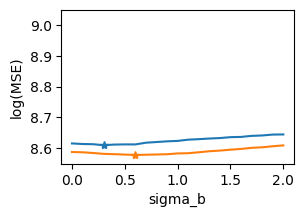

In [ ]:
L=21
plt.figure(figsize = (3, 2))
xvals = np.array(range(L))/(L-1)*2
W_val = xvals[(sum(np.isnan(mse_val)) + np.argmin(mse_val[~np.isnan(mse_val)]))]
W_test = xvals[(sum(np.isnan(mse_test)) + np.argmin(mse_test[~np.isnan(mse_test)]))]

plt.plot(xvals,np.log10(mse_val))
plt.plot(xvals, np.log10(mse_test))
plt.ylim([8.55, 9.05])
#plt.plot([1.5, 1.5], [8.5, 9])
plt.ylabel('log(MSE)')
plt.xlabel('sigma_b')
#plt.legend(['val', 'test'])
print(np.log10(mse_test))
print(W_val)
print(W_test)
mse_test_min = np.min(mse_test[~np.isnan(mse_test)])
mse_test_val = mse_test[~np.isnan(mse_test)][np.argmin(mse_val[~np.isnan(mse_val)])]
print(mse_test_min)
print(mse_test_val)
print(mse_test[0])
print(100*(mse_test_min/mse_test[0]-1))
print(100*(mse_test_val/mse_test[0]-1))
plt.plot(W_val, np.log10(np.min(mse_val[~np.isnan(mse_val)])), marker = "*", ls = None, color = "#1f77b4")
plt.plot(W_test, np.log10(np.min(mse_test[~np.isnan(mse_test)])), marker = "*", ls = None, color = "#ff7f0e")


## Coordinate descent

In [ ]:
import random
import time
from sklearn.model_selection import train_test_split
mydat_array = mydat.values
def makenpfloat(vec):
  return np.array(vec, dtype = np.float32)

import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap
import jax.numpy as jnp
import functools
import neural_tangents as nt
from neural_tangents import predict, stax
import numpy as np
from random import seed, sample
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import time
from sklearn.metrics import mean_squared_error
import torch
import random
from datetime import datetime

def unflatten(x):
  return np.reshape(x, (len(x), 1))

activations = [stax.Relu]
K = 150
B = 21
R = 81
W_vec = np.array(range(K))/10+0.1
B_vec = np.array(range(B))/10
R_vec = np.concatenate(([0], 10**((np.array(range(R))-(R-1))/10)))
seeds = [10]
nreps = len(seeds)
ntk_mat_cd = np.zeros((nreps*len(activations), 10))
for L in range(len(activations)):
  kernel_fn_list = [[] for _ in range(150)]
  activation = activations[L]
  for i in range(K):
    W_std = (i+1)/10
    for j in range(B):
      b_std = j/10
      init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(128, W_std=W_std, b_std=b_std), activation(),
        stax.Dense(1, W_std=W_std, b_std=b_std)
      )
      kernel_fn_jit = jit(kernel_fn, static_argnames='get')
      kernel_fn_list[i].append(kernel_fn_jit)
  for M in range(nreps):

    current_seed = seeds[M]

    mydat_train, mydat_val, mydat_train_emb, mydat_val_emb, mydat_train_y, mydat_val_y  = train_test_split(
        mydat_array, mydat_emb, mydat_y, test_size=340/190000,train_size=680/190000,
        stratify = mydat_emb['productType'], random_state =current_seed)

    mydat_train = makenpfloat(mydat_train)
    mydat_val = makenpfloat(mydat_val)
    mydat_train_y = makenpfloat(mydat_train_y).flatten()
    mydat_val_y = makenpfloat(mydat_val_y).flatten()

    mse_val_w = np.zeros(K)
    mse_val_b = np.zeros(B)
    mse_val_r = np.zeros(R+1)
    b_std = 0.1
    b_ind = int(10*b_std)
    W_std = 3
    diag_reg = 1e-4
    tol = 1e-4
    rel_improvement = 1
    error_old = 1e+10
    while rel_improvement > tol:
      print("W_std")
      for i in range(K):
        print(i)
        random.seed(10)
        currentW_std = (i+1)/10
        W_ind = int(10*(currentW_std -0.1))
        kernel_fn_jit = kernel_fn_list[i][b_ind]
        get = 'ntk'
        Ktrain_train = np.array(kernel_fn_jit(mydat_train, None, get))
        mytrace = np.mean(np.trace(Ktrain_train))
        Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(mydat_train_y))
        Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, get))
        alpha = np.linalg.solve(Ktrain_train_reg, mydat_train_y)
        mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
        errs_val_ntk =mypreds_val_ntk-mydat_val_y
        mse_val_w[i] = np.mean(np.square(errs_val_ntk))
      W_ind = np.argmin(mse_val_w)
      W_std = W_ind/10+0.1
      if error_old == 1e+10:
        error_old = np.min(mse_val_w)
      kernel_fn_jit = kernel_fn_list[W_ind][b_ind]
      Ktrain_train = np.array(kernel_fn_jit(mydat_train, None, get))
      Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, get))
      mytrace = np.mean(np.trace(Ktrain_train))


      print("Diag")
      for i in range(R+1):
        diag_reg = R_vec[i]
        print(i)
        Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(mydat_train_y))
        alpha = np.linalg.solve(Ktrain_train_reg, mydat_train_y)
        mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
        errs_val_ntk = mypreds_val_ntk - mydat_val_y
        mse_val_r[i] = np.mean(np.square(errs_val_ntk))
      diag_reg = R_vec[np.argmin(mse_val_r)]
      print("b_std")
      for i in range(B):
        print(i)
        kernel_fn_jit = kernel_fn_list[W_ind][i]
        Ktrain_train = np.array(kernel_fn_jit(mydat_train, None, get))
        mytrace = np.mean(np.trace(Ktrain_train))
        Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(mydat_train_y))
        Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, get))
        alpha = np.linalg.solve(Ktrain_train_reg, mydat_train_y)
        mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
        errs_val_ntk = mypreds_val_ntk - mydat_val_y
        mse_val_b[i] = np.mean(np.square(errs_val_ntk))
      error_new = np.min(mse_val_b)
      b_ind = np.argmin(mse_val_b)
      rel_improvement = np.log(error_old)-np.log(error_new)
      error_old = error_new
    W_std = W_ind/10 + 0.1
    b_std = b_ind/10
    kernel_fn_jit = kernel_fn_list[W_ind][b_ind]
    start = time.time()
    Ktrain_train = np.array(kernel_fn_jit(mydat_train, mydat_train, get))
    mytrace = np.mean(np.trace(Ktrain_train))
    Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(mydat_train_y))
    Ktrain_full = np.array(kernel_fn_jit(mydat_array, mydat_train, 'ntk'))
    Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, get))
    alpha = np.linalg.solve(Ktrain_train_reg, mydat_train_y)
    mypreds_full_ntk = np.matmul(Ktrain_full, alpha)
    mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
    end = time.time()
    time_eval = start-end
    errs_full_ntk =mypreds_full_ntk-mydat_y
    errs_val_ntk = mypreds_val_ntk - mydat_val_y
    currentind = 5*L+M
    ntk_mat_cd[currentind, 0] = np.mean(np.square(errs_full_ntk))/1e+6
    ntk_mat_cd[currentind, 1] = np.mean(np.absolute(errs_full_ntk))/1e+3
    ntk_mat_cd[currentind, 2] = np.sqrt(ntk_mat_cd[currentind, 0])/(mave/1e+3)
    ntk_mat_cd[currentind, 3] = ntk_mat_cd[currentind, 1]/(mave/1e+3)
    ntk_mat_cd[currentind, 4] = np.mean(errs_full_ntk)/mave
    ntk_mat_cd[currentind, 5] = time_eval
    ntk_mat_cd[currentind, 6] = W_std
    ntk_mat_cd[currentind, 7] = diag_reg
    ntk_mat_cd[currentind, 8] = b_std
    ntk_mat_cd[currentind, 9] = np.mean(np.square(errs_val_ntk))/1e+6

W_std
0
1
2
3
4
5


KeyboardInterrupt: 

## Separate networks NTK

In [ ]:
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap
import jax.numpy as jnp
import functools
import neural_tangents as nt
from neural_tangents import predict, stax
import numpy as np
from random import seed, sample
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import time
from sklearn.metrics import mean_squared_error
import torch
import random
#import kernel
#import eigenpro
import jax
from jax.lib import xla_bridge
import jax.profiler
from datetime import datetime

torch.cuda.is_available()
#print(jax.devices())
#print(xla_bridge.get_backend().platform)
#!nvidia-smi
K=150
b_std = 0.1
diag_reg = 0
activation = stax.Gelu
kernelfn_vec = []
for j in range(K):
  W_std = (j+1)/10
  init_fn, apply_fn, kernel_fn = stax.serial(
     stax.Dense(128, W_std=W_std, b_std=b_std), activation(),
     stax.Dense(1, W_std=W_std, b_std=b_std)
  )
  kernel_fn_jit = jit(kernel_fn, static_argnames='get')
  kernelfn_vec.append(kernel_fn_jit)




In [ ]:
def rmprod(dat):
  return np.array(dat.loc[:, dat.columns != 'productType'].values)

mse_val_ntk_mat = np.zeros((19, K))
mse_train_ntk_mat = np.zeros((19, K))
mse_remainder_ntk_mat = np.zeros((19, K))
mae_val_ntk_mat = np.zeros((19, K))
mae_remainder_ntk_mat = np.zeros((19, K))
percenterr_ntk_mat = np.zeros((19, K))
dat_train_list = []
dat_val_list = []
dat_full_list = []
dat_train_y_list = []
dat_val_y_list = []
dat_full_y_list = []

for i in range(19):
  traininds = (mydat_train_emb['productType'] == i)
  valinds = (mydat_val_emb['productType'] == i)
  shift = 10000*i
  dat_train_list.append(rmprod(mydat_train_emb[traininds]))
  dat_val_list.append(rmprod(mydat_val_emb[valinds]))
  dat_full_list.append(rmprod(mydat_emb[shift+0:shift+10000]))
  dat_train_y_list.append(mydat_train_y[traininds].flatten())
  dat_val_y_list.append(mydat_val_y[valinds].flatten())
  dat_full_y_list.append(mydat_y[shift+0:shift+10000].flatten())

for j in range(K):
  print(j)
  kernel_fn_jit = kernelfn_vec[j]

  for i in range(19):
    currentdat_train = dat_train_list[i]
    currentdat_val = dat_val_list[i]
    currentdat_full = dat_full_list[i]
    currentdat_train_y = dat_train_y_list[i]
    currentdat_val_y = dat_val_y_list[i]
    currentdat_y = dat_full_y_list[i]
    Ktrain_train = np.array(kernel_fn_jit(currentdat_train, None, 'ntk'))
    #Ktrain_train_reg = Ktrain_train + diag_reg* np.mean(np.trace(Ktrain_train))*np.identity(len(currentdat_train_y))
    Ktrain_train_reg = Ktrain_train + diag_reg* np.mean(np.trace(Ktrain_train))*np.identity(len(currentdat_train_y))
    Ktrain_full = np.array(kernel_fn_jit(currentdat_full, currentdat_train, 'ntk'))
    Ktrain_val = np.array(kernel_fn_jit(currentdat_val, currentdat_train, 'ntk'))
    alpha = np.linalg.solve(Ktrain_train_reg, currentdat_train_y)

    currentpreds_train_ntk = np.matmul(Ktrain_train, alpha)
    currentpreds_val_ntk = np.matmul(Ktrain_val, alpha)
    currentpreds_full_ntk = np.matmul(Ktrain_full, alpha)

    currenterrs_train_ntk = currentpreds_train_ntk - currentdat_train_y
    currenterrs_full_ntk = currentpreds_full_ntk - currentdat_y
    currenterrs_val_ntk = currentpreds_val_ntk - currentdat_val_y
    mse_val_ntk_mat[i, j] = np.mean(np.square(currenterrs_val_ntk))
    mse_train_ntk_mat[i, j] = np.mean(np.square(currenterrs_train_ntk))
    mae_val_ntk_mat[i, j] = np.mean(np.absolute(currenterrs_val_ntk))
    mse_remainder_ntk_mat[i, j] = np.mean(np.square(currenterrs_full_ntk))
    mae_remainder_ntk_mat[i, j] = np.mean(np.absolute(currenterrs_full_ntk))
    percenterr_ntk_mat[i, j] = np.mean(currenterrs_full_ntk)/currentdat_y.mean()

0
1
2
3
4
5
6


KeyboardInterrupt: 

### Coordinate descent

In [ ]:
import random
import time
from sklearn.model_selection import train_test_split
mydat_array = mydat.values
def makenpfloat(vec):
  return np.array(vec, dtype = np.float32)
def rmprod(dat):
  return np.array(dat.loc[:, dat.columns != 'productType'].values)

import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap
import jax.numpy as jnp
import functools
import neural_tangents as nt
from neural_tangents import predict, stax
import numpy as np
from random import seed, sample
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import time
from sklearn.metrics import mean_squared_error
import torch
import random
from datetime import datetime

def unflatten(x):
  return np.reshape(x, (len(x), 1))

activations = [stax.Relu, stax.Erf, stax.Gelu]
K = 150
B = 21
R = 81
W_vec = np.array(range(K))/10+0.1
B_vec = np.array(range(B))/10
R_vec = np.concatenate(([0], 10**((np.array(range(R))-(R-1))/10)))
seeds = [10, 20, 30, 40, 50]
nreps = 5
ntk_mat_cd_prod = np.zeros((nreps*len(activations), 7))
ntk_mat_cd_prod_sep = np.zeros((nreps*len(activations), 4, 19))


for L in range(len(activations)):
#for L in range(1):
#  if ntk_mat_b_prod[5*L+4, 0] != 0:
#    continue
  kernel_fn_list = [[] for _ in range(150)]
  activation = activations[L]
  for i in range(K):
    W_std = (i+1)/10
    for j in range(B):
      b_std = j/10
      _, _, kernel_fn = stax.serial(
        stax.Dense(128, W_std=W_std, b_std=b_std), activation(),
        stax.Dense(1, W_std=W_std, b_std=b_std)
      )
      kernel_fn_jit = jit(kernel_fn, static_argnames='get')
      kernel_fn_list[i].append(kernel_fn_jit)
  for M in range(nreps):
  # for M in range(1):
    currentind = 5*L+M
    print(currentind*100)
#    if ntk_mat_b_prod[currentind, 0] !=0:
#      continue

    current_seed = seeds[M]

    mydat_train, mydat_val, mydat_train_emb, mydat_val_emb, mydat_train_y, mydat_val_y  = train_test_split(
        mydat_array, mydat_emb, mydat_y, test_size=340/190000,train_size=680/190000,
        stratify = mydat_emb['productType'], random_state =current_seed)

    mydat_train = makenpfloat(mydat_train)
    mydat_val = makenpfloat(mydat_val)
    mydat_train_y = makenpfloat(mydat_train_y).flatten()
    mydat_val_y = makenpfloat(mydat_val_y).flatten()
    mypreds_full_ntk = np.zeros(len(mydat_y))
    mypreds_val_ntk = np.zeros(len(mydat_val_y))



    mse_val_w = np.zeros(K)
    mse_val_b = np.zeros(B)
    mse_val_r = np.zeros(R+1)
    b_vec = np.array([0.1]*19)
    b_vec_ind = [1]*19
    b1_vec = np.array([0.1]*19)
    b1_vec_ind = np.array([1]*19)
    w_vec = np.array([3]*19)
    w_vec_ind = [31]*19
    w1_vec = [0]*19
    w1_vec_ind = [0]*19
    r_vec = np.array([0]*19)
    r1_vec = np.array([1e-4]*19)
    r_vec_ind = [0]*19
    tol = 1e-4
    dat_train_list = []
    dat_val_list = []
    dat_full_list = []
    dat_train_y_list = []
    dat_val_y_list = []
    dat_full_y_list = []
    valinds_list = []


    for k in range(19):
      print(10*k)
      traininds = (mydat_train_emb['productType'] == k)
      valinds = (mydat_val_emb['productType'] == k)
      valinds_list.append(valinds)
      shift = 10000*k
      dat_train_list.append(rmprod(mydat_train_emb[traininds]))
      dat_val_list.append(rmprod(mydat_val_emb[valinds]))
      dat_full_list.append(rmprod(mydat_emb[shift+0:shift+10000]))
      dat_train_y_list.append(mydat_train_y[traininds].flatten())
      dat_val_y_list.append(mydat_val_y[valinds].flatten())
      dat_full_y_list.append(mydat_y[shift+0:shift+10000].flatten())
      diag_reg = 0
      b_ind = 1
      b_std = 0.1
      rel_improvement = 1
      niter = 0

      error_old = 1e+10

      currentdat_train = dat_train_list[k]
      currentdat_val = dat_val_list[k]
      currentdat_train_y = dat_train_y_list[k]
      currentdat_val_y = dat_val_y_list[k]
      while rel_improvement > tol:
        print(niter)
        print("W_std")
        print(diag_reg)
        print(b_std)
        for i in range(K):
          print(i)
          random.seed(10)
          kernel_fn_jit = kernel_fn_list[i][b_ind]
          get = 'ntk'
          Ktrain_train = np.array(kernel_fn_jit(currentdat_train, None, get))
          mytrace = np.mean(np.trace(Ktrain_train))
          Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(currentdat_train_y))
          Ktrain_val = np.array(kernel_fn_jit(currentdat_val, currentdat_train, get))
          alpha = np.linalg.solve(Ktrain_train_reg, currentdat_train_y)
          currentpreds_val_ntk = np.matmul(Ktrain_val, alpha)
          errs_val_ntk =currentpreds_val_ntk-currentdat_val_y
          mse_val_w[i] = np.mean(np.square(errs_val_ntk))
        W_ind = np.argmin(mse_val_w)
        w_vec_ind[k] = W_ind
        W_std = W_ind/10+0.1
        w_vec[k] = W_std
        if rel_improvement == 1:
          w1_vec[k] = W_std
          w1_vec_ind[k] = W_ind


        if error_old == 1e+10:
          error_old = np.min(mse_val_w)

        kernel_fn_jit = kernel_fn_list[W_ind][b_ind]
        Ktrain_train = np.array(kernel_fn_jit(currentdat_train, None, get))
        Ktrain_val = np.array(kernel_fn_jit(currentdat_val, currentdat_train, get))
        mytrace = np.mean(np.trace(Ktrain_train))
        print("Diag")
        print(W_std)
        print(0.1*b_ind)
        for i in range(R+1):
          diag_reg = R_vec[i]
          print(i)
          Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(currentdat_train_y))
          alpha = np.linalg.solve(Ktrain_train_reg, currentdat_train_y)
          currentpreds_val_ntk = np.matmul(Ktrain_val, alpha)
          errs_val_ntk = currentpreds_val_ntk - currentdat_val_y
          mse_val_r[i] = np.mean(np.square(errs_val_ntk))
        diag_reg = R_vec[np.argmin(mse_val_r)]
        r_vec[k] = diag_reg
        r_vec_ind[k] =np.argmin(mse_val_r)
        if rel_improvement == 1:
          r1_vec[k] = diag_reg

        print("b_std")
        print(W_std)
        print(diag_reg)
        for i in range(B):
          print(i)
          kernel_fn_jit = kernel_fn_list[W_ind][i]
          Ktrain_train = np.array(kernel_fn_jit(currentdat_train, None, get))
          mytrace = np.mean(np.trace(Ktrain_train))
          Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(currentdat_train_y))
          Ktrain_val = np.array(kernel_fn_jit(currentdat_val, currentdat_train, get))
          alpha = np.linalg.solve(Ktrain_train_reg, currentdat_train_y)
          currentpreds_val_ntk = np.matmul(Ktrain_val, alpha)
          errs_val_ntk = currentpreds_val_ntk - currentdat_val_y
          mse_val_b[i] = np.mean(np.square(errs_val_ntk))
        b_ind = np.argmin(mse_val_b)
        b_vec_ind[k] = b_ind
        b_std = 0.1*b_ind
        b_vec[k] = b_std

        if rel_improvement == 1:
          b1_vec[k] = b_ind/10
          b1_vec_ind[k] = b_ind

        error_new = np.min(mse_val_b)
        rel_improvement = np.log(error_old)-np.log(error_new)
        error_old = error_new
        niter +=1



    print("Coordinate descent")
    print(w_vec_ind)
    print(b_vec_ind)
    print(R_vec[r_vec_ind])
    currentind = 5*L+M
    start = time.time()
    for k in range(19):
      W_ind = w_vec_ind[k]
      W_std = W_ind/10 + 0.1
      b_ind = b_vec_ind[k]
      b_std = b_ind/10
      diag_reg = R_vec[r_vec_ind[k]]
      init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(128, W_std=W_std, b_std=b_std), activation(),
        stax.Dense(1, W_std=W_std, b_std=b_std)
      )
      currentdat_train = dat_train_list[k]
      currentdat_full = dat_full_list[k]
      currentdat_train_y = dat_train_y_list[k]
      currentdat_val_y = dat_val_y_list[k]
      currentdat_val = dat_val_list[k]
      currentdat_y = dat_full_y_list[k]
      kernel_fn_jit = jit(kernel_fn, static_argnames='get')

      Ktrain_train = np.array(kernel_fn_jit(currentdat_train, None, get))
      mytrace = np.mean(np.trace(Ktrain_train))
      Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(currentdat_train_y))
      Ktrain_full = np.array(kernel_fn_jit(currentdat_full, currentdat_train, 'ntk'))
      Ktrain_val = np.array(kernel_fn_jit(currentdat_val, currentdat_train, get))
      alpha = np.linalg.solve(Ktrain_train_reg, currentdat_train_y)
      shift = k*10000
      currentpreds_ntk = np.matmul(Ktrain_full, alpha)
      mypreds_full_ntk[shift+0:shift+10000] = currentpreds_ntk
      currentpreds_val_ntk = np.matmul(Ktrain_val, alpha)
      currentvalinds = valinds_list[k]
      mypreds_val_ntk[currentvalinds] = currentpreds_val_ntk
    end = time.time()
    time_eval = end-start
    errs_full_ntk =mypreds_full_ntk-mydat_y
    errs_val_ntk =mypreds_val_ntk-mydat_val_y
    currentind = 5*L+M

    ntk_mat_cd_prod[currentind, 0] = np.mean(np.square(errs_val_ntk))/1e+6
    ntk_mat_cd_prod[currentind, 1] = np.mean(np.square(errs_full_ntk))/1e+6
    ntk_mat_cd_prod[currentind, 2] = np.mean(np.absolute(errs_full_ntk))/1e+3
    ntk_mat_cd_prod[currentind, 3] = np.sqrt(ntk_mat_cd_prod[currentind, 0])/(mave/1e+3)
    ntk_mat_cd_prod[currentind, 4] = ntk_mat_cd_prod[currentind, 1]/(mave/1e+3)
    ntk_mat_cd_prod[currentind, 5] = np.mean(errs_full_ntk)/mave
    ntk_mat_cd_prod[currentind, 6] = time_eval


    #np.savetxt('NTK_mat2_CD_prod.csv', ntk_mat_cd_prod)




0
0
0
W_std
0
0.1
0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

#Kernel regression

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap
from jax.lax import fori_loop
import jax.numpy as jnp
import functools
from jax.numpy.linalg import solve
import numpy as np
from random import seed, sample
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import time
from sklearn.metrics import mean_squared_error
import torch
import random

def unflatten(x):
  return np.reshape(x, (len(x), 1))

mydat_train_y_ntk = jnp.array(unflatten(mydat_train_y))
mydat_train_ntk = jnp.array(mydat_train)
mydat_val_y_ntk = jnp.array(unflatten(mydat_val_y))
mydat_val_ntk = jnp.array(mydat_val)
mydat_y_ntk = jnp.array(unflatten(mydat_y))
mydat_array_ntk = jnp.array(mydat_array)


def gauss_const(h):
    """
    Returns the normalization constant for a gaussian
    """
    return 1/(h*np.sqrt(np.pi*2))

def makegauss_exp(ker_x, xi, h):
    const = gauss_const(h)
    den = h*h
    diffs = jnp.sum(jnp.square((xi - ker_x)), axis=xi.ndim-1)
    return const*jnp.exp(-0.5*diffs/den)

makegauss_exp_jit = jit(makegauss_exp, static_argnames = 'h')

def makegauss_exp_mat(ker_x, xi, h):
    gauss_mat = np.zeros((len(ker_x), len(xi)))
    for i in range(len(ker_x)):
        gauss_mat[i] = (makegauss_exp_jit(jnp.array(ker_x[i]), xi, h))
    return jnp.array(gauss_mat)


In [ ]:
K = 50
mae_val = np.zeros(K)
mse_val = np.zeros(K)
mae_test = np.zeros(K)
mse_test = np.zeros(K)
mse_train = np.zeros(K)
perr = np.zeros(K)
diag_reg = 1e-4


for i in range(K):
  random.seed(10)

  h = (i+1)/10
  print(h)


  Ktrain_train = makegauss_exp_mat(mydat_train_ntk, mydat_train_ntk, h)
  Ktrain_train_reg = Ktrain_train + jnp.trace(Ktrain_train)*diag_reg*jnp.identity(len(mydat_train_y))
  Ktrain_full = jnp.transpose(jnp.array(makegauss_exp_mat(mydat_train_ntk, mydat_array_ntk, h)))
  Ktrain_val = jnp.array(makegauss_exp_mat(mydat_val_ntk, mydat_train_ntk, h))
  alpha = solve(Ktrain_train_reg, mydat_train_y_ntk)
  mypreds_train_ntk = jnp.matmul(Ktrain_train, alpha)
  mypreds_val_ntk = jnp.matmul(Ktrain_val, alpha)
  mypreds_full_ntk = jnp.matmul(Ktrain_full, alpha)
  errs_ntk_train = mypreds_train_ntk - mydat_train_y_ntk
  errs_ntk_val =mypreds_val_ntk-mydat_val_y_ntk
  errs_ntk_test = mypreds_full_ntk-mydat_y_ntk
  mae_val[i] = np.mean(np.absolute(errs_ntk_val))
  mse_val[i] = np.mean(np.square(errs_ntk_val))
  mae_test[i] = np.mean(np.absolute(errs_ntk_test))
  mse_test[i] = np.mean(np.square(errs_ntk_test))
  perr[i] = np.mean(errs_ntk_test)/mydat_y.mean()
  mse_train[i] = np.mean(np.square(errs_ntk_train))


0.1
0.2


KeyboardInterrupt: 

# Greeks

In [ ]:
def getdelta1(mydat_greeks, mydat_vals):
    greeks = mydat_greeks[['Delta1']]
    greeks = greeks.join(mydat_vals[['base:1_U', 'base:1_D']])
    return greeks

greeks_train = getdelta1(mydat_greeks_train, mydat_vals_train)
greeks_val = getdelta1(mydat_greeks_val, mydat_vals_val)
greeks = getdelta1(datgreeks2, datvals2)
nmodels = len(greeks_train.columns)

##Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
nest = [500, 1000, 2000]
maxdepth = [1, 3, 5]
minsamplesleaf = [1, 5, 10]
learningrate = [0.01, 0.1, 0.2]
boost_mat = np.zeros((nmodels, 81, 5))


for m in range(nmodels):
  current_train_y =np.array(greeks_train.iloc[:, m])
  current_val_y =np.array(greeks_val.iloc[:, m])
  ncount = 0
  for i in range(3):
    currentnest = nest[i]
    for j in range(3):
      currentmaxdepth = maxdepth[j]
      for k in range(3):
        currentminsamplesleaf = minsamplesleaf[k]
        for l in range(3):
          print(ncount)
          currentlearningrate = learningrate[l]
          booster = GradientBoostingRegressor(n_estimators=currentnest,
                                              learning_rate = currentlearningrate,
                                              max_depth = currentmaxdepth,
                                              min_samples_leaf=currentminsamplesleaf,
                                              random_state=0).fit(mydat_train, current_train_y)
          val_preds = booster.predict(mydat_val)
          val_error = np.mean(np.square(val_preds.flatten() - current_val_y.flatten()))
          boost_mat[m, ncount] = [currentnest, currentmaxdepth, currentminsamplesleaf, currentlearningrate, val_error]



          ncount = ncount+1


0
1
2


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

mypreds_full_mat = np.zeros((nmodels, len(mydat_y)))
mypreds_val_mat = np.zeros((nmodels, len(mydat_val_y)))


for m in range(nmodels):
  current_train_y =np.array(greeks_train.iloc[:, m])
  current_val_y =np.array(greeks_val.iloc[:, m])
  current_y = np.array(greeks.iloc[:, m])
  mave = np.mean(np.abs(current_y))
  minind = np.argmin(boost_mat[m, :, 4])
  mynest = int(boost_mat[m, minind, 0])
  mymaxdepth = int(boost_mat[m, minind, 1])
  myminsamples = int(boost_mat[m, minind, 2])
  mylearning = boost_mat[m, minind, 3]
  booster = GradientBoostingRegressor(n_estimators=mynest, learning_rate = mylearning, max_depth = mymaxdepth, min_samples_leaf=myminsamples, random_state=0).fit(mydat_train, current_train_y)

  mypreds_full = booster.predict(mydat_array)
  mypreds_full_mat[m] = mypreds_full
  mypreds_val = booster.predict(mydat_val)
  mypreds_val_mat[m] = mypreds_val
  mypreds = booster.predict(mydat_train)
  errs = mypreds_full.flatten() - current_y.flatten()
  errs_val = mypreds_val.flatten()-current_val_y.flatten()

  print(np.mean(np.square(errs_val))/1000000)
  print(np.mean(np.square(errs))/1000000)
  print(np.mean(np.absolute(errs))/1000)
  print(np.sqrt(np.mean(np.square(errs)))/mave*100)
  print(np.mean(np.absolute(errs))/mave*100)
  print(np.mean(errs)/mave)


InvalidParameterError: The 'max_depth' parameter of GradientBoostingRegressor must be an int in the range [1, inf) or None. Got 0 instead.

In [ ]:
#boost_mat.tofile('boost_mat_delta1.csv', sep = ',')
delta1_preds_val = (mypreds_val_mat[1] - mypreds_val_mat[2])/0.02
delta1_preds_full = (mypreds_full_mat[1] - mypreds_full_mat[2])/0.02
mave = np.mean(np.abs(datgreeks2['Delta1']))
errs_preds_val = delta1_preds_val - greeks_val['Delta1']
errs_preds_full = delta1_preds_full - datgreeks2['Delta1']
print(np.mean(np.square(errs_preds_val))/1000000)
print(np.mean(np.square(errs_preds_full))/1000000)
print(np.mean(np.abs(errs_preds_full))/1000)
print(np.sqrt(np.mean(np.square(errs_preds_full)))/mave)
print(np.mean(np.abs(errs_preds_full))/mave)
print(np.mean(errs_preds_full)/np.mean(datgreeks2['Delta1']))

284726.6115197664
326667.53008593566
410.8486807788169
24.545866414416402
17.644415601051993
-1.2525933655401502


## Finite NN (Best NN)

In [ ]:
from keras.layers import Embedding
from tensorflow.keras import backend as K
nepochs = 20000
mypreds_full_mat = np.zeros((nmodels, len(mydat_y)))
mypreds_val_mat = np.zeros((nmodels, len(mydat_val_y)))
for m in range(nmodels):
  K.clear_session()
  set_random_seed(1)


  current_train_y =np.array(greeks_train.iloc[:, m])
  current_val_y =np.array(greeks_val.iloc[:, m])
  current_y = np.array(greeks.iloc[:, m])
  k = 128
  inputdata = Input((34, ))
  mydense = Dense(k, activation = 'relu')(inputdata)
  mydense = Dense(int(k/2), activation = 'relu')(mydense)
  myval = Dense(1)(mydense)

  inputs = inputdata
  outputs = myval

  m1 = KerasModel(inputs = inputs, outputs=outputs)
  m1.compile(optimizer=Adam(), loss='mse')
  #m1.summary()
  callback = EarlyStopping(monitor='val_loss', patience=50)
  m1.fit(x=mydat_train, y=current_train_y, epochs = nepochs, validation_data = (mydat_val, current_val_y), callbacks = [callback], verbose = 0, batch_size = n)


  mave = np.mean(np.abs(current_y))
  mypreds_train = m1.predict(x=mydat_train).flatten()
  errs_train = mypreds_train - current_train_y
  mypreds_val  = m1.predict(x=mydat_val).flatten()
  errs_val = mypreds_val - current_val_y
  mse_val_1 = np.mean(np.square(errs_val)/1000000)
  mypreds_full  = m1.predict(x=mydat_array).flatten()
  errs = mypreds_full - current_y

  K.clear_session()
  set_random_seed(1)



  input_product_type = Input(shape=(1,))
  output_product_type = Embedding(19, 5, name='product_type_embedding')(input_product_type)
  output_product_type = Reshape(target_shape=(5,))(output_product_type)
  input_mat = Input(shape = (15, ))
  output_mat = input_mat
  input_list = [input_mat, input_product_type]
  outputs =[output_mat, output_product_type]
  outputs = Concatenate()(outputs)
  k = 128

  outputs = Dense(k, activation = 'relu')(outputs)
  outputs = Dense(int(k/2), activation = 'relu')(outputs)
  outputs = Dense(1)(outputs)

  m2 = KerasModel(inputs = input_list, outputs=outputs)
  m2.compile(optimizer=Adam(), loss='mse')
  #m2.summary()
  callback = EarlyStopping(monitor='val_loss', patience=50)


  def split_features(dat_emb):
    product_type = np.array(dat_emb['productType']).astype('float')
    dat_emb = np.array(dat_emb.loc[:, dat_emb.columns != 'productType'].values)
    return [dat_emb, product_type]


  m2.fit(x=split_features(mydat_train_emb), y=current_train_y, epochs = nepochs, validation_data = (split_features(mydat_val_emb), current_val_y), callbacks = [callback], verbose = 0, batch_size = n)

  mypreds2_val = m2.predict(x=split_features(mydat_val_emb)).flatten()
  mypreds2_train = m2.predict(x=split_features(mydat_train_emb)).flatten()
  errs2_train = mypreds2_train - current_train_y
  errs2_val = mypreds2_val - current_val_y
  mse_val_2 = np.mean(np.square(errs2_val)/1000000)
  mypreds2_full  = m2.predict(x=split_features(mydat_emb)).flatten()
  errs2 = mypreds2_full - current_y

  if mse_val_1 > mse_val_2:
    errs_best = errs2
    mypreds_full_mat[m] = mypreds2_full
  else:
    errs_best = errs
    mypreds_full_mat[m] = mypreds_full

  print(np.min([mse_val_1, mse_val_2]))
  print(np.mean(np.square(errs_best))/1000000)
  print(np.mean(np.abs(errs_best))/1000)
  print(np.sqrt(np.mean(np.square(errs_best)))/mave)
  print(np.mean(np.abs(errs_best))/mave)
  print(np.mean(errs_best)/np.mean(current_y))

delta1_preds_val = (mypreds_val_mat[1] - mypreds_val_mat[2])/0.02
delta1_preds_full = (mypreds_full_mat[1] - mypreds_full_mat[2])/0.02
mave = np.mean(np.abs(datgreeks2['Delta1']))
errs_preds_val = delta1_preds_val - greeks_val['Delta1']
errs_preds_full = delta1_preds_full - datgreeks2['Delta1']
print(np.mean(np.square(errs_preds_val))/1000000)
print(np.mean(np.square(errs_preds_full))/1000000)
print(np.mean(np.abs(errs_preds_full))/1000)
print(np.sqrt(np.mean(np.square(errs_preds_full)))/mave)
print(np.mean(np.abs(errs_preds_full))/mave)
print(np.mean(errs_preds_full)/np.mean(datgreeks2['Delta1']))


KeyboardInterrupt: 

## NTK

In [ ]:
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap
import jax.numpy as jnp
import functools
import neural_tangents as nt
from neural_tangents import predict, stax
import numpy as np
from random import seed, sample
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import time
from sklearn.metrics import mean_squared_error
import torch
import random
from datetime import datetime

def unflatten(x):
  return np.reshape(x, (len(x), 1))

#greeks_train_ntk = jnp.array(greeks_train)
mydat_train_ntk = jnp.array(mydat_train)
#greeks_val_ntk = jnp.array(greeks_val)
mydat_val_ntk = jnp.array(mydat_val)
#greeks_ntk = jnp.array(greeks)
mydat_array_ntk = jnp.array(mydat_array)

In [ ]:
K = 150
mae_val = np.zeros((nmodels, K))
mse_val = np.zeros((nmodels, K))
mae_test = np.zeros((nmodels, K))
mse_test = np.zeros((nmodels, K))
#pmae_test = np.zeros((nmodels, K))
#prmse_test = np.zeros((nmodels, K))
mse_train = np.zeros((nmodels, K))
perr = np.zeros((nmodels, K))
mypreds_full_mat = np.zeros((nmodels, len(mydat_y)))
mypreds_val_mat = np.zeros((nmodels, len(mydat_val_y)))
b_std = 0.1
diag_reg = 1e-4
myactivation = stax.Gelu

for m in [0]:
  current_train_y = jnp.array(unflatten(greeks_train.iloc[:, m]))
  current_val_y = jnp.array(unflatten(greeks_val.iloc[:, m]))
  current_y = jnp.array(unflatten(greeks.iloc[:, m]))
  mave = np.mean(np.abs(current_y))
  for i in range(K):
    random.seed(10)

    W_std = (i+1)/10
    print(W_std)

    init_fn, apply_fn, kernel_fn = stax.serial(
      stax.Dense(128, W_std=W_std, b_std=b_std), myactivation(),
      stax.Dense(1, W_std=W_std, b_std=b_std)
    )



    kernel_fn_jit = jit(kernel_fn, static_argnames='get')
    get = 'ntk'

    predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn_jit, mydat_train_ntk, current_train_y, diag_reg = diag_reg)
    mypreds_train_ntk = predict_fn(x_test=mydat_train_ntk, get=get, compute_cov=False).flatten()
    mypreds_val_ntk = predict_fn(x_test=mydat_val_ntk, get=get, compute_cov=False).flatten()
    mypreds_full_ntk = predict_fn(x_test=mydat_array_ntk, get=get, compute_cov=False).flatten()
    errs_ntk_train = mypreds_train_ntk - current_train_y
    errs_ntk_val =mypreds_val_ntk-current_val_y.flatten()
    errs_ntk_test = mypreds_full_ntk-current_y.flatten()

    mae_val[m, i] = np.mean(np.absolute(errs_ntk_val))
    mse_val[m, i] = np.mean(np.square(errs_ntk_val))
    mae_test[m, i] = np.mean(np.absolute(errs_ntk_test))
    mse_test[m, i] = np.mean(np.square(errs_ntk_test))
    #pmae_test[m, i] = np.mean(np.absolute(errs_ntk_test))/mave
    #prmse_test[m, i] = np.sqrt(np.mean(np.square(errs_ntk_test)))/mave
    perr[m, i] = np.mean(errs_ntk_test)/current_y.mean()
    mse_train[m, i] = np.mean(np.square(errs_ntk_train))

  random.seed(10)
  current_mse_val = mse_val[m]
  W_std = (sum(np.isnan(current_mse_val)) + np.argmin(current_mse_val[~np.isnan(current_mse_val)]))/10+0.1
  b_std = 0.1

  init_fn, apply_fn, kernel_fn = stax.serial(
      stax.Dense(128, W_std=W_std, b_std=b_std), myactivation(),
      stax.Dense(1, W_std=W_std, b_std=b_std)
  )



  start = time.time()
  kernel_fn_jit = jit(kernel_fn, static_argnames='get')
  get = 'ntk'
  predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn_jit, mydat_train_ntk, current_train_y, diag_reg = diag_reg)
  mypreds_train_ntk = predict_fn(x_test=mydat_train_ntk, get=get, compute_cov=False).flatten()
  mypreds_val_ntk = predict_fn(x_test=mydat_val_ntk, get=get, compute_cov=False).flatten()
  mypreds_full_ntk = predict_fn(x_test=mydat_array_ntk, get=get, compute_cov=False).flatten()
  end = time.time()
  mypreds_full_mat[:,m] = mypreds_full_ntk[m]
  mypreds_val_mat[:,m] = mypreds_val_ntk[m]

  print(np.mean(np.square(mypreds_val_ntk-current_val_y.flatten())))
  errs_ntk = current_y.flatten() - mypreds_full_ntk
  print(np.mean(np.square(errs_ntk)))
  print(np.mean(np.absolute(errs_ntk)))
  print(np.sqrt(np.mean(np.square(errs_ntk)))/mave*100)
  print(np.mean(np.absolute(errs_ntk))/mave*100)
  print(np.mean(errs_ntk)/current_y.mean()*100)

0.1
0.2


KeyboardInterrupt: 

## NTK CD

In [ ]:
import random
import time
from sklearn.model_selection import train_test_split
mydat_array = mydat.values
def makenpfloat(vec):
  return np.array(vec, dtype = np.float32)


import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap
import jax.numpy as jnp
import functools
import neural_tangents as nt
from neural_tangents import predict, stax
import numpy as np
from random import seed, sample
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import time
from sklearn.metrics import mean_squared_error
import torch
import random
from datetime import datetime

def unflatten(x):
  return np.reshape(x, (len(x), 1))

activations = [stax.Relu, stax.Erf, stax.Gelu]
K = 150
B = 21
R = 81
W_vec = np.array(range(K))/10+0.1
B_vec = np.array(range(B))/10
R_vec = np.concatenate(([0], 10**((np.array(range(R))-(R-1))/10)))
seeds = [10, 20, 30, 40, 50]
nreps = len(seeds)
ntk_mat_cd = np.zeros((nmodels, nreps*len(activations), 10))
mypreds_full_mat = np.zeros((nmodels, nreps*len(activations), len(mydat_array)))
mypreds_val_mat = np.zeros((nmodels, nreps*len(activations), len(mydat_val)))
for L in range(len(activations)):
  kernel_fn_list = [[] for _ in range(150)]
  activation = activations[L]
  for i in range(K):
    W_std = (i+1)/10
    for j in range(B):
      b_std = j/10
      init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(128, W_std=W_std, b_std=b_std), activation(),
        stax.Dense(1, W_std=W_std, b_std=b_std)
      )
      kernel_fn_jit = jit(kernel_fn, static_argnames='get')
      kernel_fn_list[i].append(kernel_fn_jit)
  for M in range(nreps):

    current_seed = seeds[M]

    mydat_train, mydat_val, mydat_train_emb, mydat_val_emb, mydat_train_y, mydat_val_y  = train_test_split(
        mydat_array, mydat_emb, mydat_y, test_size=340/190000,train_size=680/190000,
        stratify = mydat_emb['productType'], random_state =current_seed)

    mydat_train = makenpfloat(mydat_train)
    mydat_val = makenpfloat(mydat_val)
    mydat_greeks_train = datgreeks2.loc[mydat_train_emb.index]
    mydat_greeks_val = datgreeks2.loc[mydat_val_emb.index]
    mydat_vals_train = datvals2.loc[mydat_train_emb.index]
    mydat_vals_val = datvals2.loc[mydat_val_emb.index]
    for m in [0, 1, 2]:
      current_train_y = greeks_train.iloc[:, m]
      current_val_y = greeks_val.iloc[:, m]
      current_y = greeks.iloc[:, m]
      mave = np.mean(np.abs(current_y))

      mse_val_w = np.zeros(K)
      mse_val_b = np.zeros(B)
      mse_val_r = np.zeros(R+1)
      b_std = 0.1
      b_ind = int(10*b_std)
      W_std = 3
      diag_reg = 1e-4
      tol = 1e-4
      rel_improvement = 1
      error_old = 1e+10
      while rel_improvement > tol:
        print("W_std")
        for i in range(K):
          print(i)
          random.seed(10)
          currentW_std = (i+1)/10
          W_ind = int(10*(currentW_std -0.1))
          kernel_fn_jit = kernel_fn_list[i][b_ind]
          get = 'ntk'
          Ktrain_train = np.array(kernel_fn_jit(mydat_train, None, get))
          mytrace = np.mean(np.trace(Ktrain_train))
          Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(current_train_y))
          Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, get))
          alpha = np.linalg.solve(Ktrain_train_reg, current_train_y)
          mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
          errs_val_ntk =mypreds_val_ntk-current_val_y
          mse_val_w[i] = np.mean(np.square(errs_val_ntk))
        W_ind = np.argmin(mse_val_w)
        W_std = W_ind/10+0.1
        if error_old == 1e+10:
          error_old = np.min(mse_val_w)
        kernel_fn_jit = kernel_fn_list[W_ind][b_ind]
        Ktrain_train = np.array(kernel_fn_jit(mydat_train, None, get))
        Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, get))
        mytrace = np.mean(np.trace(Ktrain_train))







        print("Diag")
        for i in range(R+1):
          diag_reg = R_vec[i]
          print(i)
          Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(current_train_y))
          alpha = np.linalg.solve(Ktrain_train_reg, current_train_y)
          mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
          errs_val_ntk = mypreds_val_ntk - current_val_y
          mse_val_r[i] = np.mean(np.square(errs_val_ntk))
        diag_reg = R_vec[np.argmin(mse_val_r)]
        print("b_std")
        for i in range(B):
          print(i)
          kernel_fn_jit = kernel_fn_list[W_ind][i]
          Ktrain_train = np.array(kernel_fn_jit(mydat_train, None, get))
          mytrace = np.mean(np.trace(Ktrain_train))
          Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(current_train_y))
          Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, get))
          alpha = np.linalg.solve(Ktrain_train_reg, current_train_y)
          mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
          errs_val_ntk = mypreds_val_ntk - current_val_y
          mse_val_b[i] = np.mean(np.square(errs_val_ntk))
        error_new = np.min(mse_val_b)
        b_ind = np.argmin(mse_val_b)
        rel_improvement = np.log(error_old)-np.log(error_new)
        error_old = error_new
    W_std = W_ind/10 + 0.1
    b_std = b_ind/10
    kernel_fn_jit = kernel_fn_list[W_ind][b_ind]
    start = time.time()
    Ktrain_train = np.array(kernel_fn_jit(mydat_train, mydat_train, get))
    mytrace = np.mean(np.trace(Ktrain_train))
    Ktrain_train_reg = Ktrain_train + diag_reg*mytrace*np.identity(len(current_train_y))
    Ktrain_full = np.array(kernel_fn_jit(mydat_array, mydat_train, 'ntk'))
    Ktrain_val = np.array(kernel_fn_jit(mydat_val, mydat_train, 'ntk'))
    alpha = np.linalg.solve(Ktrain_train_reg, current_train_y)
    mypreds_full_ntk = np.matmul(Ktrain_full, alpha)
    mypreds_val_ntk = np.matmul(Ktrain_val, alpha)
    end = time.time()
    time_eval = start-end
    errs_full_ntk =mypreds_full_ntk-current_y
    errs_val_ntk = mypreds_val_ntk - current_val_y
    currentind = nreps*L + M
    mse_val_ntk = np.mean(np.square(errs_val_ntk))
    mse_full_ntk = np.mean(np.square(errs_full_ntk))
    mae_full_ntk = np.mean(np.abs(errs_full_ntk))

    ntk_mat_cd[m, currentind, 0] = mse_full_ntk/1e+6
    ntk_mat_cd[m, currentind, 1] = mae_full_ntk/1e+3
    ntk_mat_cd[m, currentind, 2] = np.sqrt(mse_full_ntk)/(mave/1e+3)
    ntk_mat_cd[m, currentind, 3] = mae_full_ntk/(mave/1e+3)
    ntk_mat_cd[m, currentind, 4] = np.mean(errs_full_ntk)/current_y.mean()
    ntk_mat_cd[m, currentind, 5] = time_eval
    ntk_mat_cd[m, currentind, 6] = W_std
    ntk_mat_cd[m, currentind, 7] = diag_reg
    ntk_mat_cd[m, currentind, 8] = b_std
    ntk_mat_cd[m, currentind, 9] = mse_val_ntk/1e+6
    mypreds_full_mat[m, currentind, :] = mypreds_full_ntk
    mypreds_val_mat[m, currentind, :] = mypreds_val_ntk




Exception ignored in: <function _xla_gc_callback at 0x79efb82012d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


W_std
0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

In [ ]:
delta1_preds_val = (mypreds_val_mat[1, :, :] - mypreds_val_mat[2, :, :])/0.02
delta1_preds_full = (mypreds_full_mat[1, :, :] - mypreds_full_mat[2, :, :])/0.02
mave = np.mean(np.abs(datgreeks2['Delta1']))
errs_preds_val = np.zeros(delta1_preds_val.shape)
errs_preds_full = np.zeros(delta1_preds_full.shape)
for i in range(len(delta1_preds_val)):
  errs_preds_val[i] = delta1_preds_val[i] - greeks_val['Delta1']
  errs_preds_full[i] = delta1_preds_full[i] - datgreeks2['Delta1']
  print(np.mean(np.square(errs_preds_val[i]))/1000000)
  print(np.mean(np.square(errs_preds_full[i]))/1000000)
  print(np.mean(np.abs(errs_preds_full[i]))/1000)
  print(np.sqrt(np.mean(np.square(errs_preds_full[i])))/mave)
  print(np.mean(np.abs(errs_preds_full[i]))/mave)
  print(np.mean(errs_preds_full[i])/np.mean(datgreeks2['Delta1']))


69452094.38379914
89833967.71040913
5171.485931756038
407.0480445381255
222.09599622402342
217.2921123792474
70036630.93689649
94976884.31274377
5169.805694645452
418.5374665901622
222.0238363187481
219.07093385917625
70515048.95992176
95533022.77511007
5172.865022515053
419.76105398938375
222.1552230188071
219.5342420844305


## Hejazi

In [ ]:
from sklearn.model_selection import train_test_split

mydat_trainr, mydat_rep, mydat_trainr_y, mydat_rep_y = train_test_split(mydat_train_emb, mydat_train_y, test_size = 0.5, train_size = 0.5, random_state = random_state)
print(len(mydat_rep), len(mydat_trainr), len(mydat_val))

mydat_greeks_trainr = datgreeks2.loc[mydat_trainr.index]
mydat_greeks_rep = datgreeks2.loc[mydat_rep.index]
delta_trainr = np.array(mydat_greeks_trainr['Delta1'])
delta_rep = np.array(mydat_greeks_rep['Delta1'])
delta_val = np.array(mydat_greeks_val['Delta1'])
delta_full = np.array(greeks['Delta1'])

340 340 340


In [ ]:
#first, we need a function which evaluates the "distance vector"
#there are three components:

#first, distance on each categorical variable is a Hamming distance
def getcatdist(catvec2, catvec1):
  return 1*np.array(catvec2 != catvec1)

#second, positive distance on numerics: max(y2-y1, 0)
#third, (absolute) negative distance on numerics: max(y1-y2, 0)

def getmaxdist(numvec2, numvec1):
  numvec2 = np.array(numvec2)
  numvec1 = np.array(numvec1)
  return 1*np.maximum(numvec2-numvec1, 0)

def getmindist(numvec2, numvec1):
  numvec2 = np.array(numvec2)
  numvec1 = np.array(numvec1)
  return 1*np.maximum(numvec1-numvec2, 0)

#if we concatenate catdist, maxdist and mindist, we get a vector of length 30

#this creates a list of n_rep matrices of shape (n_pred x 30)
#this allows defining in Tensorflow the list of inputs [dat1, dat2, ..., datn_rep] where each dat is a dataset with n_pred rows
def getdist (list_rep, list_pred):
  datcat_rep = list_rep[0]
  datnum_rep = list_rep[1]
  datcat_pred = list_pred[0]
  datnum_pred = list_pred[1]
  distlist = []
  for i in range(len(list_rep[0])):
    currentcat = getcatdist(datcat_rep.iloc[i], datcat_pred)
    currentmax = getmaxdist(datnum_rep.iloc[i], datnum_pred)
    currentmin = getmindist(datnum_rep.iloc[i], datnum_pred)
    currentdist = np.concatenate([currentcat, currentmax, currentmin], axis=1)
    distlist.append(currentdist)
  return distlist

mydat_trainr_cat = mydat_trainr[['gender', 'productType']]
mydat_trainr_num = mydat_trainr.loc[:, ~mydat_trainr.columns.isin(['gender', 'productType'])]
mydat_trainr_list = [mydat_trainr_cat, mydat_trainr_num]
mydat_rep_cat = mydat_rep[['gender', 'productType']]
mydat_rep_num = mydat_rep.loc[:, ~mydat_rep.columns.isin(['gender', 'productType'])]
mydat_rep_list = [mydat_rep_cat, mydat_rep_num]
mydat_val_cat = mydat_val_emb[['gender', 'productType']]
mydat_val_num = mydat_val_emb.loc[:, ~mydat_val_emb.columns.isin(['gender', 'productType'])]
mydat_val_list = [mydat_val_cat, mydat_val_num]
mydat_cat = mydat_emb[['gender', 'productType']]
mydat_num = mydat_emb.loc[:, ~mydat_emb.columns.isin(['gender', 'productType'])]
mydat_list = [mydat_cat, mydat_num]

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
set_random_seed(1)
inputlist = []
denselist = []
nrep = len(mydat_rep)
for i in range(nrep):
  inputlist.append(Input((30, ), name = 'input'+str(i)))
  #for each policy in the representative portfolio, calculate distance vector of target policy to the rep policy
  denselist.append(Dense(1, name = 'dense'+str(i))(inputlist[i]))
  #map each distance vector via an affine function to a single neuron. affine functions are distinct
weights = Concatenate()(denselist)
weights = Softmax()(weights)
#concatenate the n_rep neurons, and then apply softmax to obtain weights
output = Dense(1, use_bias = False, name = 'weightedval', trainable=False)(weights)
#by introducing a dense layer on these weights, these weights will each be multiplied by a number and summed
#we force the dense layer to be nontrainable, and set the number which the weights will be multiplied by
#to be the representative portfolio values, in order to achieve this effect
m = KerasModel(inputs = inputlist, outputs = output)
m.get_layer('weightedval').set_weights([np.reshape(np.array(delta_rep), (len(delta_rep), 1))])
#this forces the weights to each multiply by the representative portfolio values
m.compile(optimizer=Adam(), loss='mse')
#m.summary()
callback = EarlyStopping(monitor='val_loss', patience=50)
trainr_dist = getdist(mydat_rep_list, mydat_trainr_list)
val_dist = getdist(mydat_rep_list, mydat_val_list)
m.fit(x=trainr_dist, y=delta_trainr, epochs = 20000, validation_data = (val_dist, delta_val), callbacks = [callback], verbose = 1, batch_size = 16)

Epoch 1/20000


KeyboardInterrupt: 

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


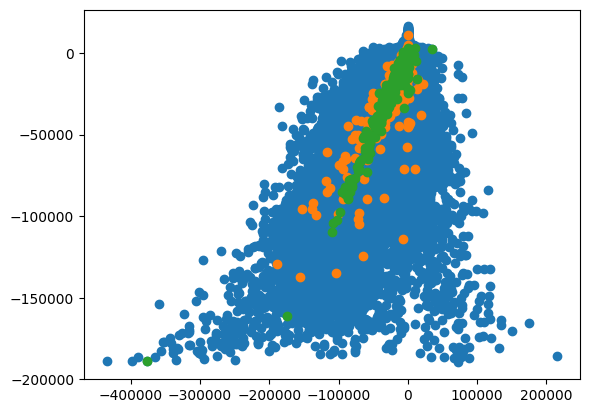

In [ ]:
neval = 2048
nfull = len(mydat_y)
niters = nfull//neval +1
predslist = []
for i in range(niters):
  start = int(neval*i)
  stop = int(np.min([neval*(i+1), nfull]))
  currentlist = [mydat_cat[start:stop], mydat_num[start:stop]]
  currentdist = getdist(mydat_rep_list, currentlist)
  predslist.append(m.predict(x=currentdist))
mypreds_full = np.concatenate(predslist)
mypreds_val = m.predict(x=val_dist)
mypreds_trainr = m.predict(x=trainr_dist)

import matplotlib.pyplot as plt
#plt.scatter(mydat_remainder_y, mypreds_remainder)
plt.scatter(delta_full, mypreds_full)
plt.scatter(delta_val, mypreds_val)
plt.scatter(delta_trainr, mypreds_trainr)
errs = mypreds_full.flatten() - delta_full
errs_val = mypreds_val.flatten() - delta_val
errs_trainr = mypreds_trainr.flatten() - delta_trainr
mave_delta = np.mean(np.abs(delta_full))

errs_zero = errs[delta_full != 0]
errs_val_zero = errs_val[delta_val != 0]
mave_delta_zero = np.mean(np.abs(delta_full[delta_full!=0]))

mse_full = np.mean(np.square(errs))
mae_full = np.mean(np.abs(errs))
mse_val = np.mean(np.abs(errs_val))
mse_trainr = np.mean(np.square(errs_trainr))

mse_full_zero = np.mean(np.square(errs_zero))
mae_full_zero = np.mean(np.abs(errs_zero))
mse_val_zero = np.mean(np.square(errs_val_zero))

print(mse_val/1e+6)
print(mse_full/1e+6)
print(mae_full/1e+6)
print(np.sqrt(mse_full)/mave_delta)
print(mae_full/mave_delta)

print(mse_val_zero/1e+6)
print(mse_full_zero/1e+6)
print(mae_full_zero/1e+6)
print(np.sqrt(mse_full_zero)/mave_delta_zero)
print(mae_full_zero/mave_delta_zero)


In [ ]:
errs = mypreds_full.flatten() - delta_full
errs_val = mypreds_val.flatten() - delta_val
errs_trainr = mypreds_trainr.flatten() - delta_trainr
mave_delta = np.mean(np.abs(delta_full))

errs_zero = errs[delta_full != 0]
errs_val_zero = errs_val[delta_val != 0]
mave_delta_zero = np.mean(np.abs(delta_full[delta_full!=0]))

mse_full = np.mean(np.square(errs))
mae_full = np.mean(np.abs(errs))
mse_val = np.mean(np.abs(errs_val))
mse_trainr = np.mean(np.square(errs_trainr))

mse_full_zero = np.mean(np.square(errs_zero))
mae_full_zero = np.mean(np.abs(errs_zero))
mse_val_zero = np.mean(np.square(errs_val_zero))


print(mse_val/1e+6)
print(mse_full/1e+6)
print(mae_full/1e+6)
print(np.sqrt(mse_full)/mave_delta)
print(mae_full/mave_delta)

print(mse_val_zero/1e+6)
print(mse_full_zero/1e+6)
print(mae_full_zero/1e+6)
print(np.sqrt(mse_full_zero)/mave_delta_zero)
print(mae_full_zero/mave_delta_zero)
print(np.min(delta_rep))
print(np.max(delta_rep))
print(np.min(delta_full))
print(np.max(delta_full))

0.010973296849433486
347.5195387944415
0.010847399546469395
0.8005989118790109
0.46585527651142244
312.06583284197694
364.1904764495889
0.010941282158558007
0.734944742161615
0.4213651494226546
-190559.835
57562.14925
-435069.7555
216124.5184
